# Canadian Wildfire Risk Prediction and Geospatial Analysis

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, precision_recall_curve
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

data = pd.read_csv('filtered_NFDB_data.csv')
data.head()

/var/folders/n3/wq3qj7vn3c12xjhrsq0nrmcr0000gn/T/ipykernel_7869/4065905802.py:9: DtypeWarning: Columns (2,4,11,12,16,17,18,19,20,21,22,25,26,28,29,35,37,39,40,41,43,44,45,46,48) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('filtered_NFDB_data.csv')


,NFDBFIREID,SRC_AGENCY,NAT_PARK,FIRE_ID,FIRENAME,LATITUDE,LONGITUDE,YEAR,MONTH,DAY,...,CAUSE.1,CAUSE2.1,FIRE_TYPE.1,RESPONSE.1,PROTZONE.1,PRESCRIBED.1,MORE_INFO.1,CFS_NOTE1.1,CFS_NOTE2.1,ACQ_DATE.1
0,BC-2023-2023-C23369,BC,NaN,2023-C23369,C23369,51.8197,-122.0729,2023,9,27,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BC-2023-2023-R50580,BC,NaN,2023-R50580,KITSELAS ROAD,54.5692,-128.4611,2023,6,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,BC-2023-2023-K40937,BC,NaN,2023-K40937,NaN,50.1166,-119.2738,2023,6,27,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BC-2023-2023-R10108,BC,NaN,2023-R10108,LAUREL ROAD,54.2270,-125.6543,2023,4,28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,BC-2023-2023-K50058,BC,NaN,2023-K50058,Campbell Mountain,49.5187,-119.5348,2023,4,17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [2]:
# Check for missing values in each column
missing_data = data.isnull().sum()

# Calculate the percentage of missing values for each column
missing_percentage = (missing_data / len(data)) * 100

# Combine the count and percentage of missing values in a single DataFrame
missing_info = pd.DataFrame({'Missing Values': missing_data, 'Percentage': missing_percentage})

# Display columns that have missing values
missing_info = missing_info[missing_info['Missing Values'] > 0].sort_values(by='Percentage', ascending=False)
print(missing_info)

              Missing Values  Percentage
NAT_PARK.1            371060  100.000000
CFS_NOTE2.1           371060  100.000000
RESPONSE.1            371060  100.000000
ATTK_DATE.1           371060  100.000000
PRESCRIBED.1          371057   99.999192
CFS_NOTE1.1           371039   99.994341
ATTK_DATE             370858   99.945561
PRESCRIBED            370574   99.869024
CFS_NOTE2             369997   99.713523
FIRENAME.1            368933   99.426777
NAT_PARK              367161   98.949227
PROTZONE.1            364809   98.315367
MORE_INFO.1           357664   96.389802
RESPONSE              354378   95.504231
CFS_NOTE1             354225   95.462998
OUT_DATE.1            351635   94.764998
FIRE_TYPE.1           340160   91.672506
CAUSE.1               331656   89.380693
CAUSE2.1              331656   89.380693
SIZE_HA.1             331656   89.380693
DAY.1                 331656   89.380693
REP_DATE.1            331656   89.380693
LATITUDE.1            331656   89.380693
MONTH.1         

In [3]:
# Define a threshold for missing values (e.g., 80%)
threshold = 80

# Drop columns where the percentage of missing values is above the threshold
columns_to_drop = missing_info[missing_info['Percentage'] > threshold].index

# Drop those columns from the dataset
data_cleaned = data.drop(columns=columns_to_drop)

# Print the remaining columns
print("Remaining columns after dropping those with more than 80% missing values:")
print(data_cleaned.columns)

Remaining columns after dropping those with more than 80% missing values:
Index(['NFDBFIREID', 'SRC_AGENCY', 'FIRE_ID', 'LATITUDE', 'LONGITUDE', 'YEAR',
       'MONTH', 'DAY', 'REP_DATE', 'OUT_DATE', 'SIZE_HA', 'CAUSE', 'CAUSE2',
       'FIRE_TYPE', 'PROTZONE', 'ACQ_DATE', 'geometry'],
      dtype='object')


In [4]:
# Check for missing values in the cleaned dataset
remaining_missing_data = data_cleaned.isnull().sum()

# Calculate the percentage of missing values for each column in the cleaned dataset
remaining_missing_percentage = (remaining_missing_data / len(data_cleaned)) * 100

# Combine the count and percentage of missing values in a DataFrame
remaining_missing_info = pd.DataFrame({'Missing Values': remaining_missing_data, 'Percentage': remaining_missing_percentage})

# Display columns that still have missing values
print(remaining_missing_info[remaining_missing_info['Missing Values'] > 0])

           Missing Values  Percentage
FIRE_ID               165    0.044467
REP_DATE             3991    1.075567
OUT_DATE           210582   56.751469
FIRE_TYPE          141960   38.257964
PROTZONE           284902   76.780575
ACQ_DATE             8948    2.411470


In [5]:
# Drop rows with missing values in 'FIRE_ID', 'REP_DATE', and 'ACQ_DATE'
data_cleaned = data_cleaned.dropna(subset=['FIRE_ID', 'REP_DATE', 'ACQ_DATE'])

# Drop rows with missing values in 'FIRE_TYPE'
data_cleaned = data_cleaned.dropna(subset=['FIRE_TYPE'])

# Check the remaining shape of the dataset
print(f"Remaining rows after dropping missing values: {data_cleaned.shape}")

Remaining rows after dropping missing values: (229055, 17)


In [6]:
# Fill missing 'OUT_DATE' with a placeholder
data_cleaned['OUT_DATE'].fillna('unknown', inplace=True)

# Drop the 'PROTZONE' column due to excessive missing data
data_cleaned = data_cleaned.drop(columns=['PROTZONE'])

# Check the final shape and missing values
print(f"Remaining columns and rows: {data_cleaned.shape}")
print(f"Remaining missing values:\n{data_cleaned.isnull().sum()}")

Remaining columns and rows: (229055, 16)
Remaining missing values:
NFDBFIREID    0
SRC_AGENCY    0
FIRE_ID       0
LATITUDE      0
LONGITUDE     0
YEAR          0
MONTH         0
DAY           0
REP_DATE      0
OUT_DATE      0
SIZE_HA       0
CAUSE         0
CAUSE2        0
FIRE_TYPE     0
ACQ_DATE      0
geometry      0
dtype: int64


In [7]:
# Get summary statistics for numerical columns
summary_stats = data_cleaned.describe()
summary_stats

,LATITUDE,LONGITUDE,YEAR,MONTH,DAY,SIZE_HA
count,229055.000000,229055.000000,229055.000000,229055.000000,229055.000000,229055.000000
mean,52.658975,-117.341508,1991.072786,6.795743,15.432682,176.158664
std,2.988914,8.987710,19.358840,1.585317,9.005126,4234.230938
min,4.522700,-188.075000,1930.000000,1.000000,0.000000,0.000000
25%,50.160900,-122.000550,1977.000000,6.000000,7.000000,0.100000
50%,52.107000,-119.183800,1992.000000,7.000000,15.000000,0.100000
75%,54.972050,-115.468650,2007.000000,8.000000,23.000000,0.600000
max,63.033000,-52.660000,2023.000000,12.000000,31.000000,619072.500000


In [8]:
# Filter out unrealistic latitude and longitude values
data_cleaned_filtered = data_cleaned[
    (data_cleaned['LATITUDE'] >= -90) & (data_cleaned['LATITUDE'] <= 90) &
    (data_cleaned['LONGITUDE'] >= -180) & (data_cleaned['LONGITUDE'] <= 180)
]

In [9]:
data_cleaned_filtered.isnull().sum()


NFDBFIREID    0
SRC_AGENCY    0
FIRE_ID       0
LATITUDE      0
LONGITUDE     0
YEAR          0
MONTH         0
DAY           0
REP_DATE      0
OUT_DATE      0
SIZE_HA       0
CAUSE         0
CAUSE2        0
FIRE_TYPE     0
ACQ_DATE      0
geometry      0
dtype: int64

In [10]:
data_cleaned_filtered.shape

(229054, 16)

In [ ]:
#Correlation Heatmap

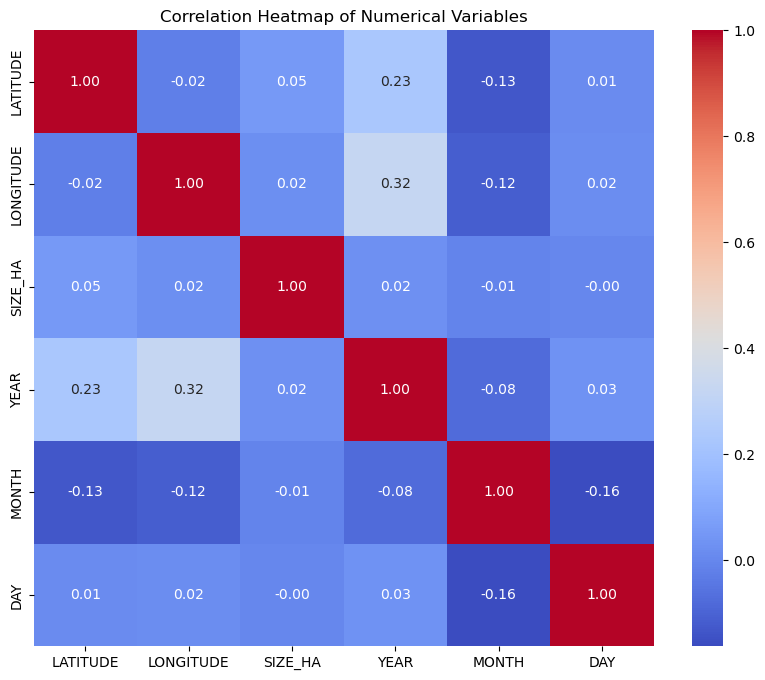

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select numerical columns for correlation analysis
numerical_columns = ['LATITUDE', 'LONGITUDE', 'SIZE_HA', 'YEAR', 'MONTH', 'DAY']

# Calculate the correlation matrix
correlation_matrix = data_cleaned_filtered[numerical_columns].corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Numerical Variables')
plt.show()


In [ ]:
#Fire Size Correlation with Other Variables

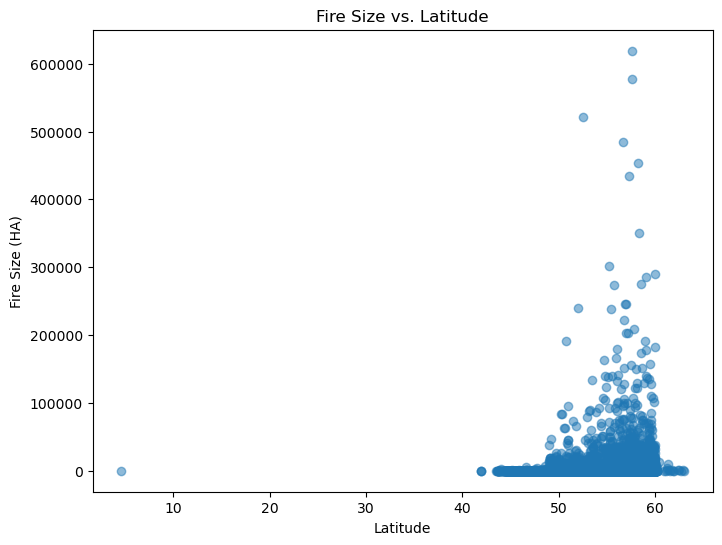

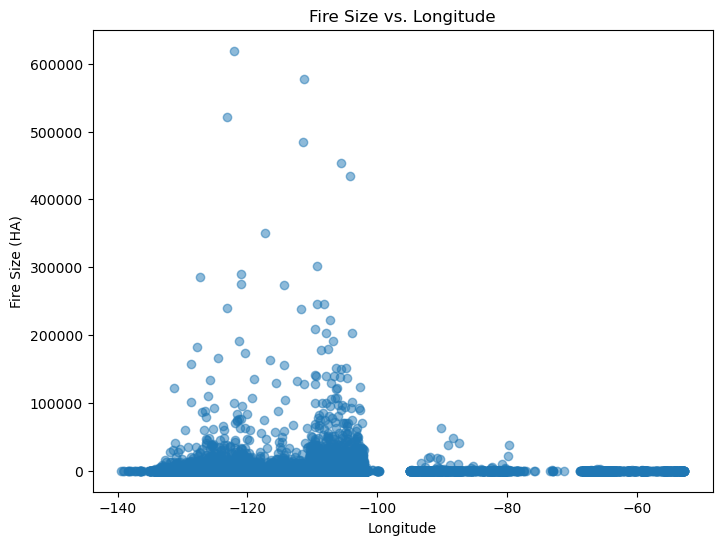

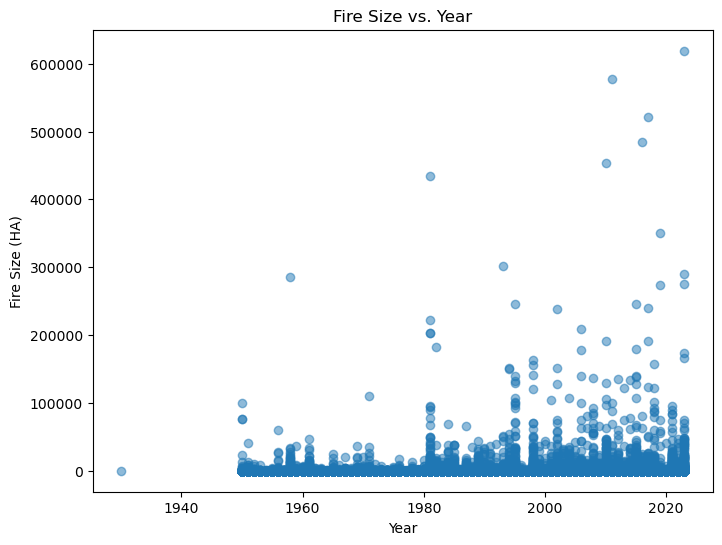

In [12]:
# Scatter plot for Fire Size vs. Latitude
plt.figure(figsize=(8, 6))
plt.scatter(data_cleaned_filtered['LATITUDE'], data_cleaned_filtered['SIZE_HA'], alpha=0.5)
plt.title('Fire Size vs. Latitude')
plt.xlabel('Latitude')
plt.ylabel('Fire Size (HA)')
plt.show()

# Scatter plot for Fire Size vs. Longitude
plt.figure(figsize=(8, 6))
plt.scatter(data_cleaned_filtered['LONGITUDE'], data_cleaned_filtered['SIZE_HA'], alpha=0.5)
plt.title('Fire Size vs. Longitude')
plt.xlabel('Longitude')
plt.ylabel('Fire Size (HA)')
plt.show()

# Scatter plot for Fire Size vs. Year
plt.figure(figsize=(8, 6))
plt.scatter(data_cleaned_filtered['YEAR'], data_cleaned_filtered['SIZE_HA'], alpha=0.5)
plt.title('Fire Size vs. Year')
plt.xlabel('Year')
plt.ylabel('Fire Size (HA)')
plt.show()

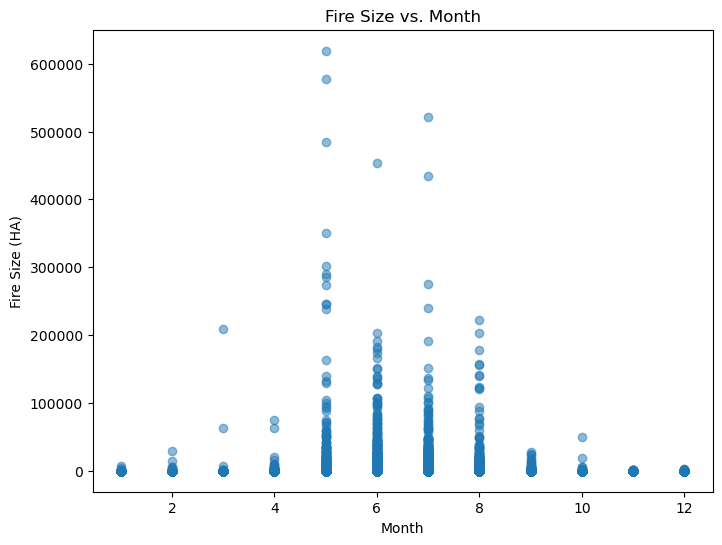

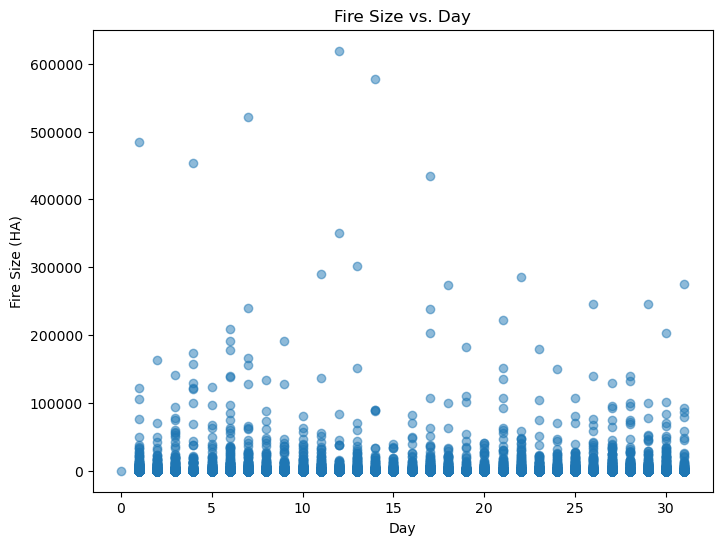

In [13]:
# Scatter plot for Fire Size vs. Month
plt.figure(figsize=(8, 6))
plt.scatter(data_cleaned_filtered['MONTH'], data_cleaned_filtered['SIZE_HA'], alpha=0.5)
plt.title('Fire Size vs. Month')
plt.xlabel('Month')
plt.ylabel('Fire Size (HA)')
plt.show()

# Scatter plot for Fire Size vs. Day
plt.figure(figsize=(8, 6))
plt.scatter(data_cleaned_filtered['DAY'], data_cleaned_filtered['SIZE_HA'], alpha=0.5)
plt.title('Fire Size vs. Day')
plt.xlabel('Day')
plt.ylabel('Fire Size (HA)')
plt.show()


In [ ]:
#Fire Size by Cause

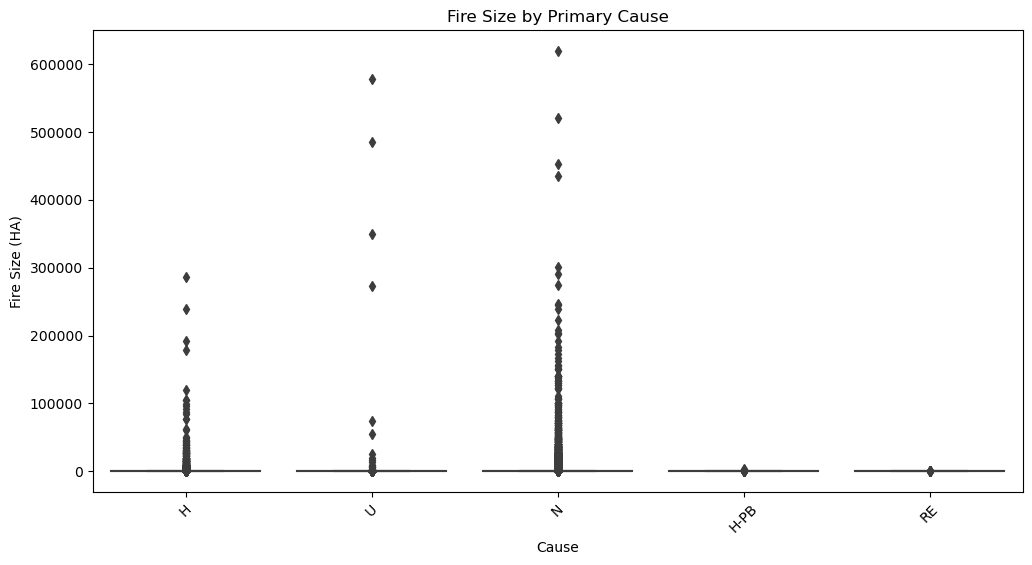

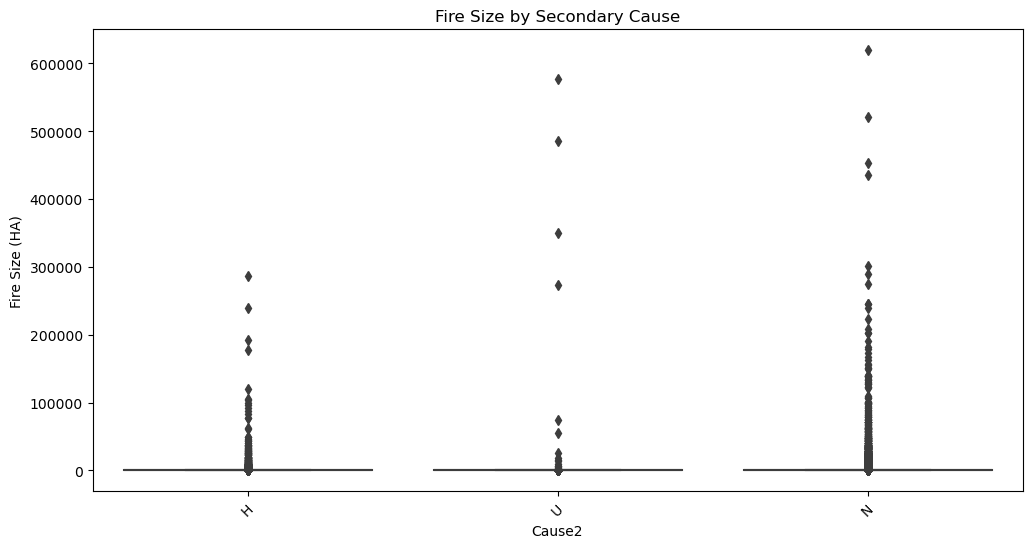

In [14]:
import seaborn as sns

# Boxplot for Fire Size by Primary Cause
plt.figure(figsize=(12, 6))
sns.boxplot(x='CAUSE', y='SIZE_HA', data=data_cleaned_filtered)
plt.title('Fire Size by Primary Cause')
plt.xlabel('Cause')
plt.ylabel('Fire Size (HA)')
plt.xticks(rotation=45)
plt.show()

# Boxplot for Fire Size by Secondary Cause (if relevant)
plt.figure(figsize=(12, 6))
sns.boxplot(x='CAUSE2', y='SIZE_HA', data=data_cleaned_filtered)
plt.title('Fire Size by Secondary Cause')
plt.xlabel('Cause2')
plt.ylabel('Fire Size (HA)')
plt.xticks(rotation=45)
plt.show()


In [ ]:
#Geospatial Analysis

In [ ]:
#Geospatial Distribution of Fire Incidents

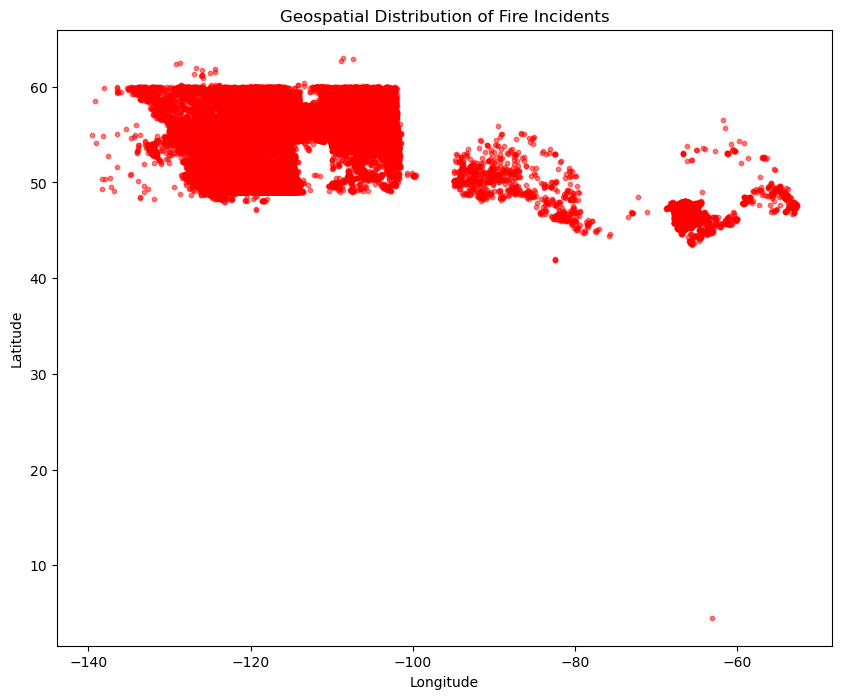

In [15]:
# Scatter plot for spatial distribution of fire incidents
plt.figure(figsize=(10, 8))
plt.scatter(data_cleaned_filtered['LONGITUDE'], data_cleaned_filtered['LATITUDE'], alpha=0.5, s=10, color='red')
plt.title('Geospatial Distribution of Fire Incidents')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [ ]:
#Geospatial Distribution with Map Context

/var/folders/n3/wq3qj7vn3c12xjhrsq0nrmcr0000gn/T/ipykernel_7869/4007910112.py:4: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


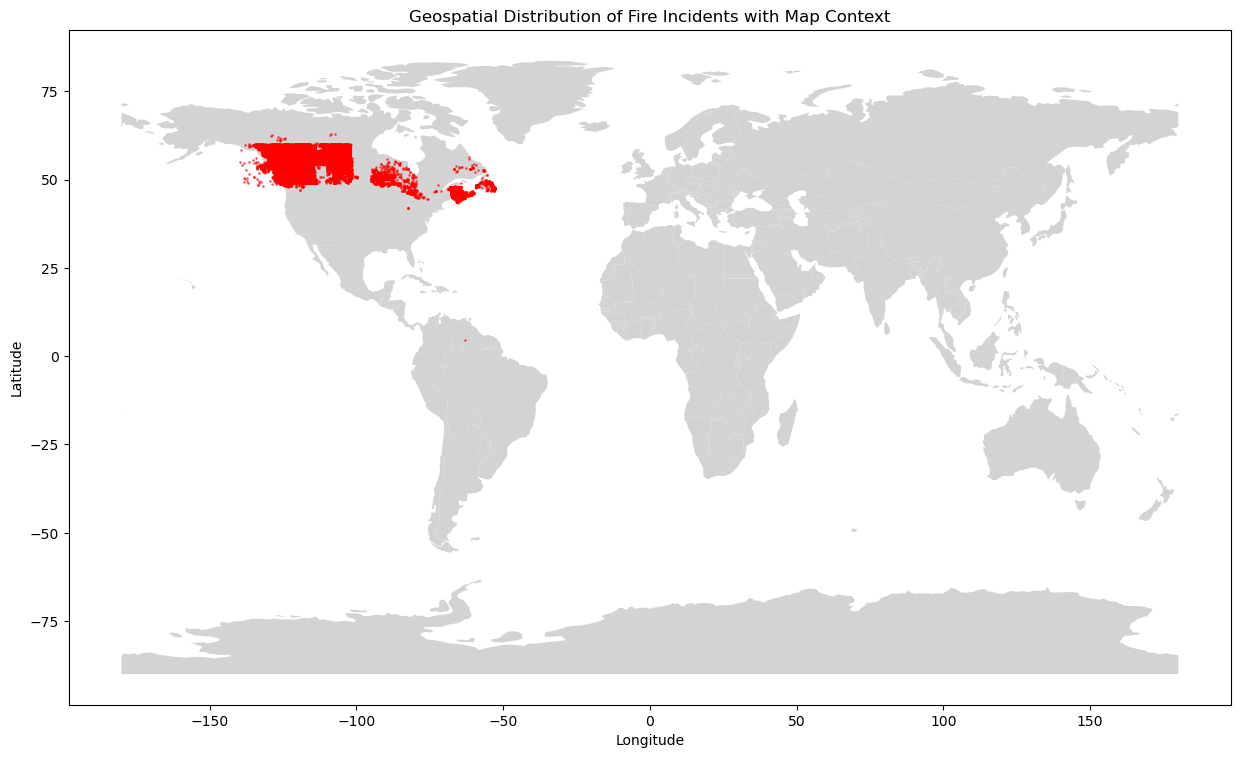

In [16]:
import geopandas as gpd

# Load world map data using GeoPandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Create a GeoDataFrame from the fire incidents
gdf = gpd.GeoDataFrame(
    data_cleaned_filtered, 
    geometry=gpd.points_from_xy(data_cleaned_filtered['LONGITUDE'], data_cleaned_filtered['LATITUDE']),
    crs="EPSG:4326"
)

# Plot the world map with fire incidents
fig, ax = plt.subplots(figsize=(15, 10))
world.plot(ax=ax, color='lightgrey')
gdf.plot(ax=ax, markersize=1, color='red', alpha=0.5)
plt.title('Geospatial Distribution of Fire Incidents with Map Context')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


In [ ]:
#Geospatial Clustering (K-Means)

/Users/rafat/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/n3/wq3qj7vn3c12xjhrsq0nrmcr0000gn/T/ipykernel_7869/1148940447.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned_filtered['cluster'] = kmeans.labels_


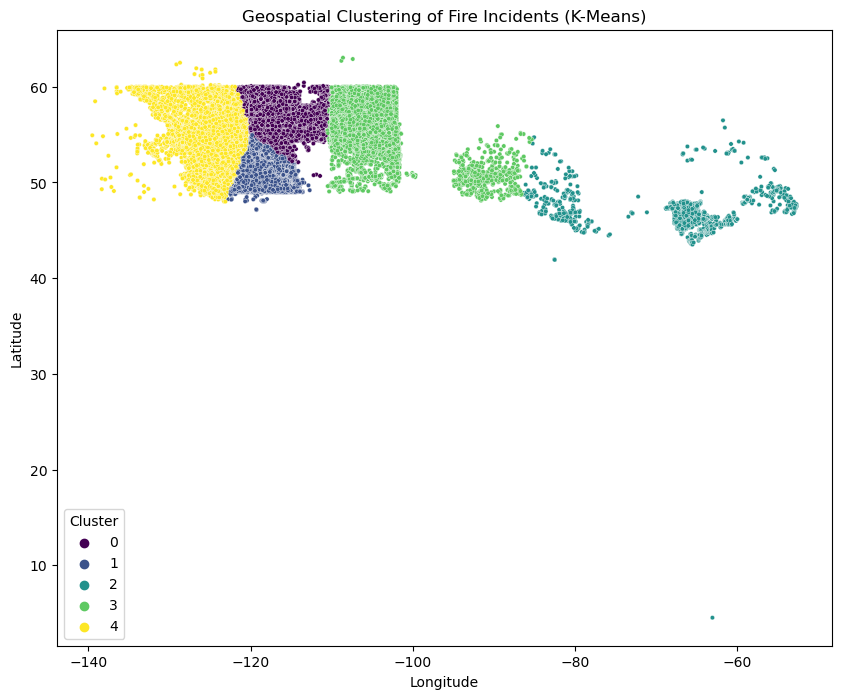

In [17]:
from sklearn.cluster import KMeans

# Extract coordinates for clustering
coords = data_cleaned_filtered[['LATITUDE', 'LONGITUDE']]

# Perform K-Means clustering (choose an arbitrary number of clusters, e.g., 5)
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(coords)
data_cleaned_filtered['cluster'] = kmeans.labels_

# Plot the clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(x='LONGITUDE', y='LATITUDE', hue='cluster', palette='viridis', data=data_cleaned_filtered, s=10)
plt.title('Geospatial Clustering of Fire Incidents (K-Means)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Cluster')
plt.show()


In [ ]:
#Fire Density Heatmap

/var/folders/n3/wq3qj7vn3c12xjhrsq0nrmcr0000gn/T/ipykernel_7869/967447199.py:7: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  k = kde.gaussian_kde([x, y])


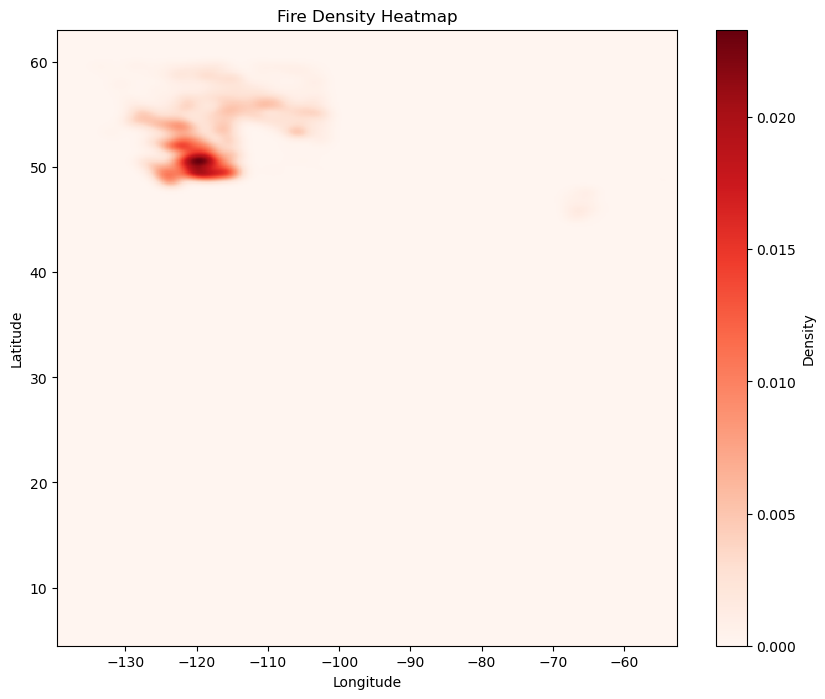

In [18]:
import numpy as np
from scipy.stats import kde

# Evaluate a gaussian kde on a regular grid
x = data_cleaned_filtered['LONGITUDE']
y = data_cleaned_filtered['LATITUDE']
k = kde.gaussian_kde([x, y])
xi, yi = np.mgrid[x.min():x.max():500j, y.min():y.max():500j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

# Make the density plot
plt.figure(figsize=(10, 8))
plt.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='auto', cmap='Reds')
plt.colorbar(label='Density')
plt.title('Fire Density Heatmap')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


In [ ]:
#Temporal Trends Analysis

In [ ]:
#Distribution of Fires Over the Years

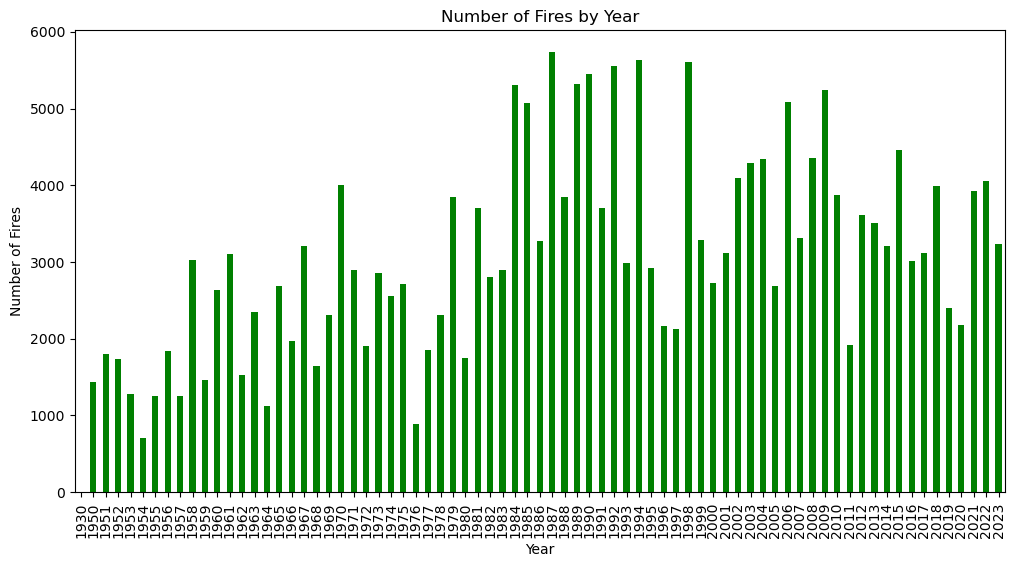

In [19]:
# Plot the number of fires per year
plt.figure(figsize=(12, 6))
data_cleaned_filtered['YEAR'].value_counts().sort_index().plot(kind='bar', color='green')
plt.title('Number of Fires by Year')
plt.xlabel('Year')
plt.ylabel('Number of Fires')
plt.show()


In [ ]:
#Average Fire Size by Year

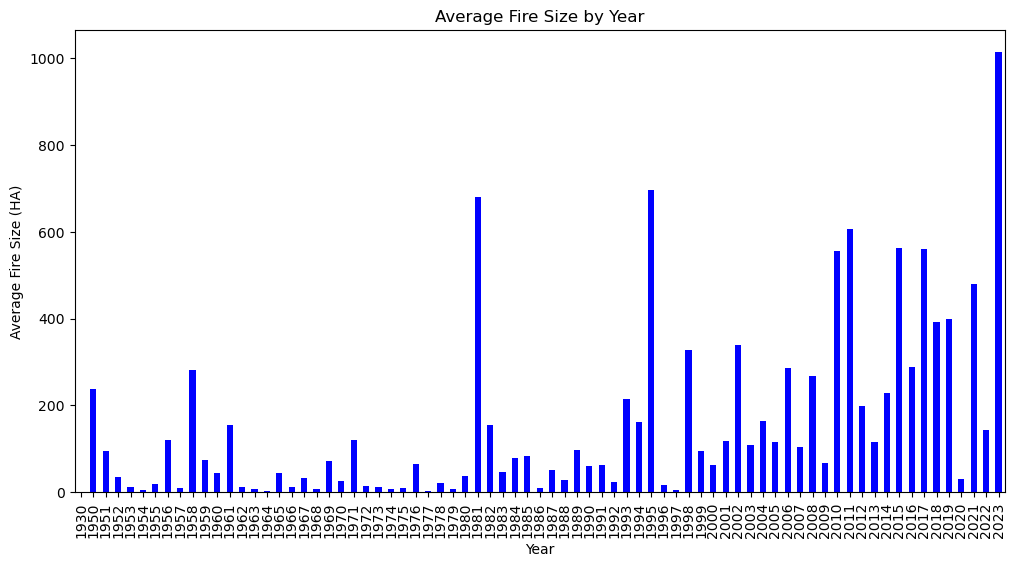

In [20]:
# Plot the average fire size per year
plt.figure(figsize=(12, 6))
data_cleaned_filtered.groupby('YEAR')['SIZE_HA'].mean().plot(kind='bar', color='blue')
plt.title('Average Fire Size by Year')
plt.xlabel('Year')
plt.ylabel('Average Fire Size (HA)')
plt.show()


In [ ]:
#Number of Fires by Month

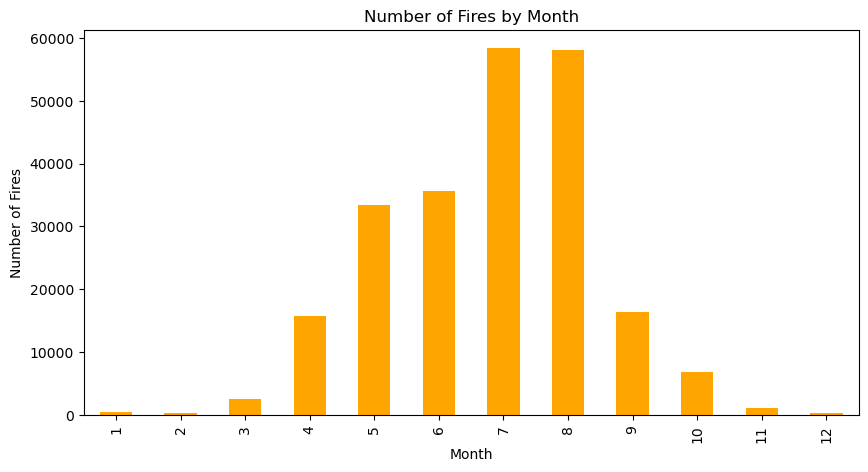

In [21]:
# Plot the number of fires per month
plt.figure(figsize=(10, 5))
data_cleaned_filtered['MONTH'].value_counts().sort_index().plot(kind='bar', color='orange')
plt.title('Number of Fires by Month')
plt.xlabel('Month')
plt.ylabel('Number of Fires')
plt.show()


In [ ]:
#Average Fire Size by Month

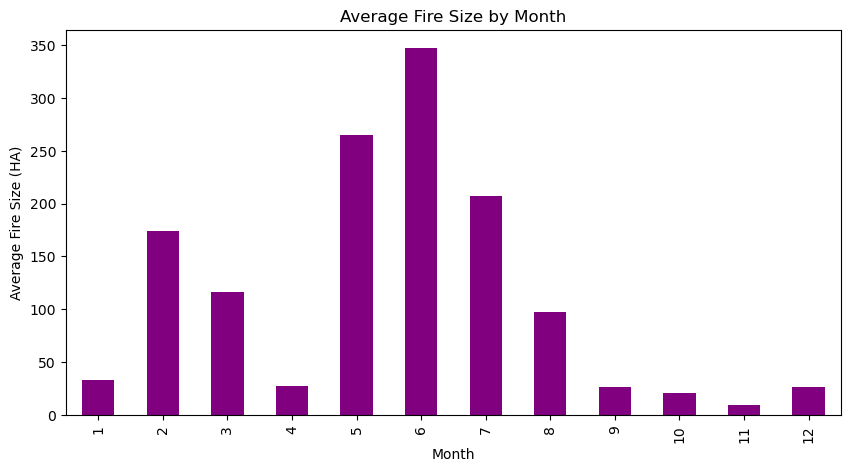

In [22]:
# Plot the average fire size per month
plt.figure(figsize=(10, 5))
data_cleaned_filtered.groupby('MONTH')['SIZE_HA'].mean().plot(kind='bar', color='purple')
plt.title('Average Fire Size by Month')
plt.xlabel('Month')
plt.ylabel('Average Fire Size (HA)')
plt.show()


In [ ]:
#Create a New YEAR_MONTH Column for Detailed Analysis

/var/folders/n3/wq3qj7vn3c12xjhrsq0nrmcr0000gn/T/ipykernel_7869/3205707810.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned_filtered['YEAR_MONTH'] = data_cleaned_filtered['YEAR'].astype(str) + '-' + data_cleaned_filtered['MONTH'].astype(str).str.zfill(2)


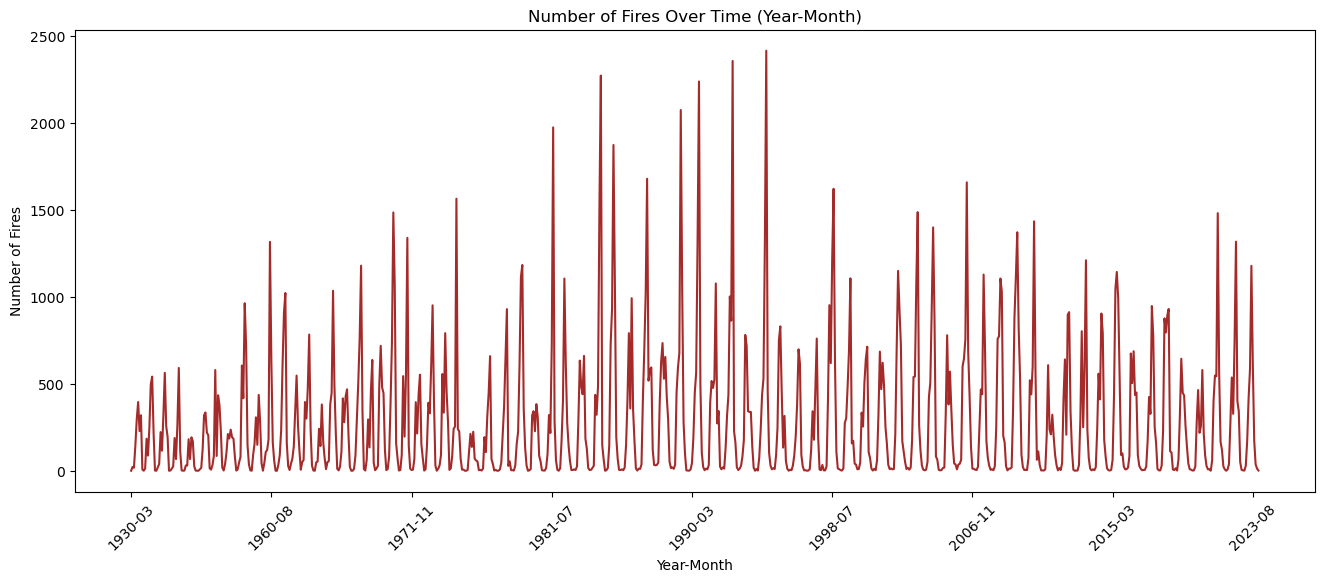

In [23]:
# Create a new 'YEAR_MONTH' column
data_cleaned_filtered['YEAR_MONTH'] = data_cleaned_filtered['YEAR'].astype(str) + '-' + data_cleaned_filtered['MONTH'].astype(str).str.zfill(2)

# Plot the number of fires by year and month
plt.figure(figsize=(16, 6))
data_cleaned_filtered['YEAR_MONTH'].value_counts().sort_index().plot(kind='line', color='brown')
plt.title('Number of Fires Over Time (Year-Month)')
plt.xlabel('Year-Month')
plt.ylabel('Number of Fires')
plt.xticks(rotation=45)
plt.show()


In [ ]:
#Provincial/Regional Analysis

In [ ]:
#Top Regions by Number of Fires

/var/folders/n3/wq3qj7vn3c12xjhrsq0nrmcr0000gn/T/ipykernel_7869/201151979.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned_filtered['Region'] = pd.cut(data_cleaned_filtered['LONGITUDE'], bins=5, labels=['West', 'Mid-West', 'Central', 'East', 'Far East'])


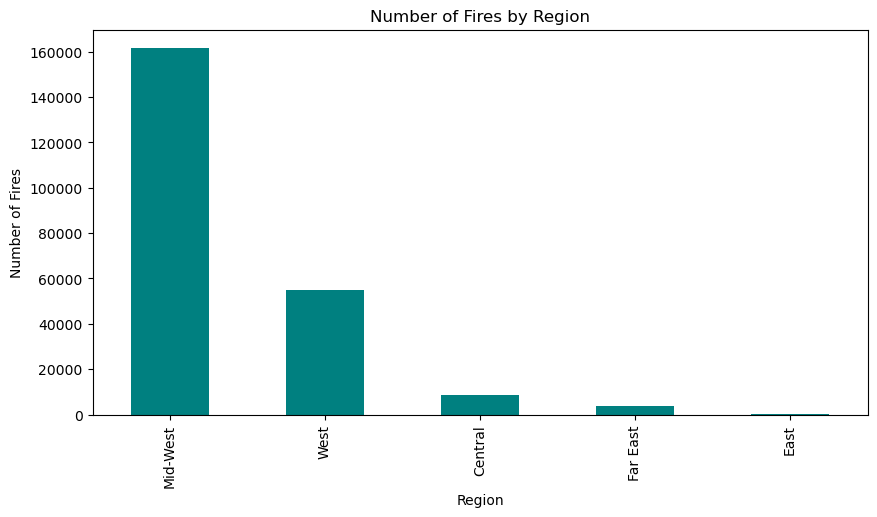

In [24]:
# Creating a simple clustering using longitude to approximate regions
# Using longitude to segment the regions for simplicity
data_cleaned_filtered['Region'] = pd.cut(data_cleaned_filtered['LONGITUDE'], bins=5, labels=['West', 'Mid-West', 'Central', 'East', 'Far East'])

# Plotting the number of fires by region
plt.figure(figsize=(10, 5))
data_cleaned_filtered['Region'].value_counts().plot(kind='bar', color='teal')
plt.title('Number of Fires by Region')
plt.xlabel('Region')
plt.ylabel('Number of Fires')
plt.show()


In [ ]:
#Average Fire Size by Region

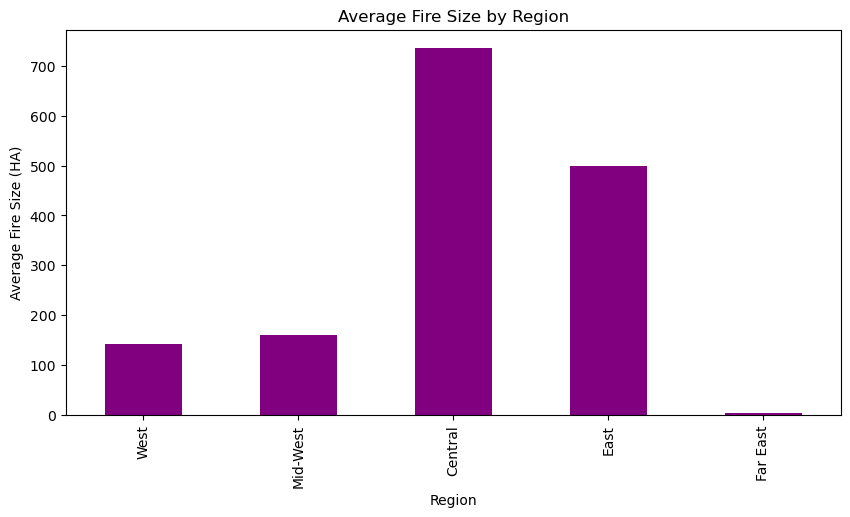

In [25]:
# Plotting the average fire size by region
plt.figure(figsize=(10, 5))
data_cleaned_filtered.groupby('Region')['SIZE_HA'].mean().plot(kind='bar', color='purple')
plt.title('Average Fire Size by Region')
plt.xlabel('Region')
plt.ylabel('Average Fire Size (HA)')
plt.show()


In [ ]:
#Main Causes of Wildfires by Region

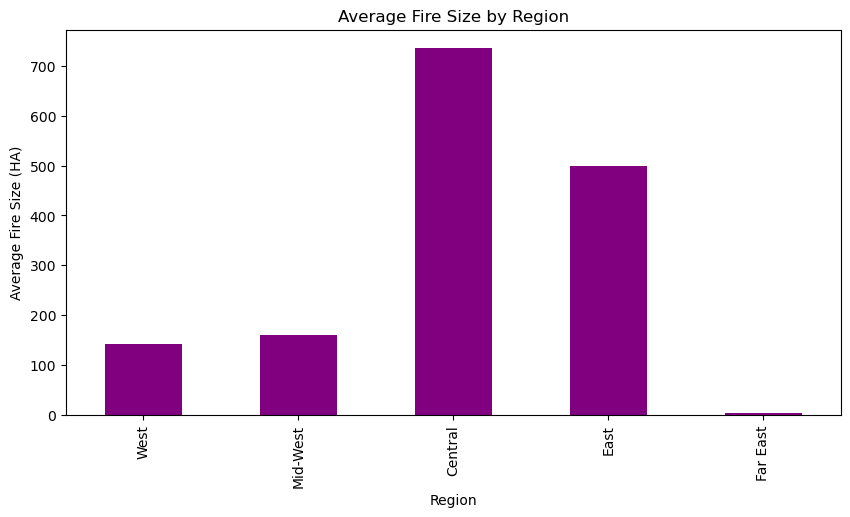

In [26]:
# Plotting the average fire size by region
plt.figure(figsize=(10, 5))
data_cleaned_filtered.groupby('Region')['SIZE_HA'].mean().plot(kind='bar', color='purple')
plt.title('Average Fire Size by Region')
plt.xlabel('Region')
plt.ylabel('Average Fire Size (HA)')
plt.show()


In [ ]:
#Average Fire Size by Cause and Region

/var/folders/n3/wq3qj7vn3c12xjhrsq0nrmcr0000gn/T/ipykernel_7869/3680429625.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=data_cleaned_filtered, x='Region', y='SIZE_HA', hue='CAUSE', ci=None, palette='viridis')


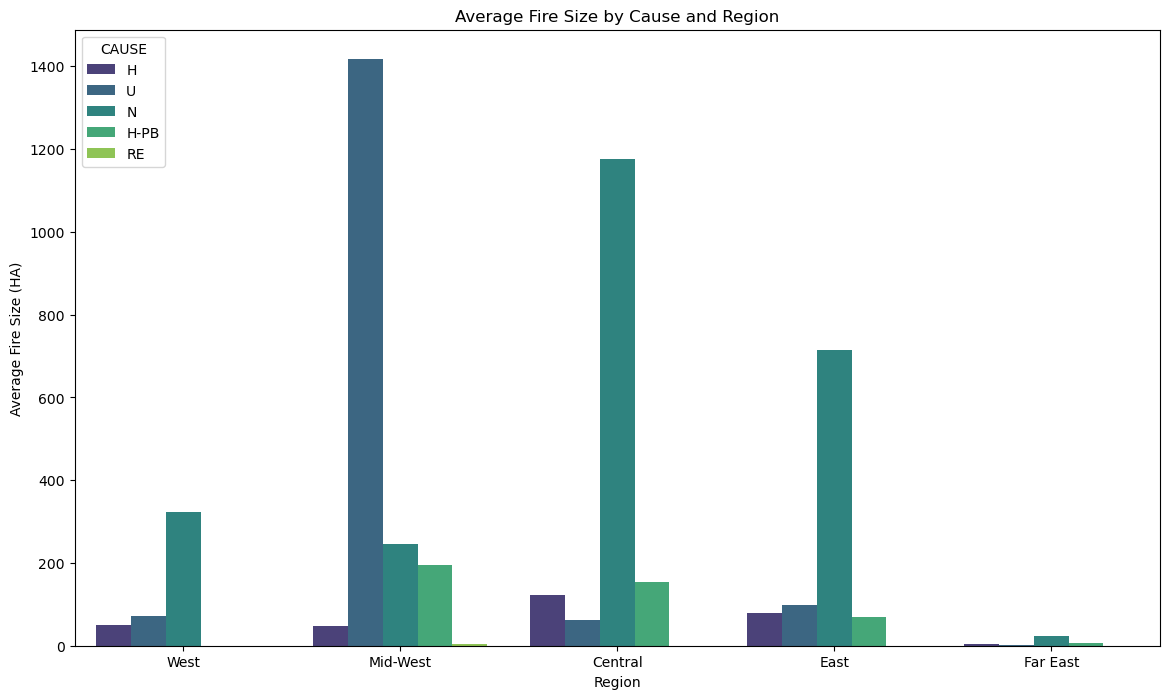

In [27]:
# Plotting average fire size by cause and region
plt.figure(figsize=(14, 8))
sns.barplot(data=data_cleaned_filtered, x='Region', y='SIZE_HA', hue='CAUSE', ci=None, palette='viridis')
plt.title('Average Fire Size by Cause and Region')
plt.xlabel('Region')
plt.ylabel('Average Fire Size (HA)')
plt.show()


In [ ]:
#Temporal Trend of Fires in Top Regions

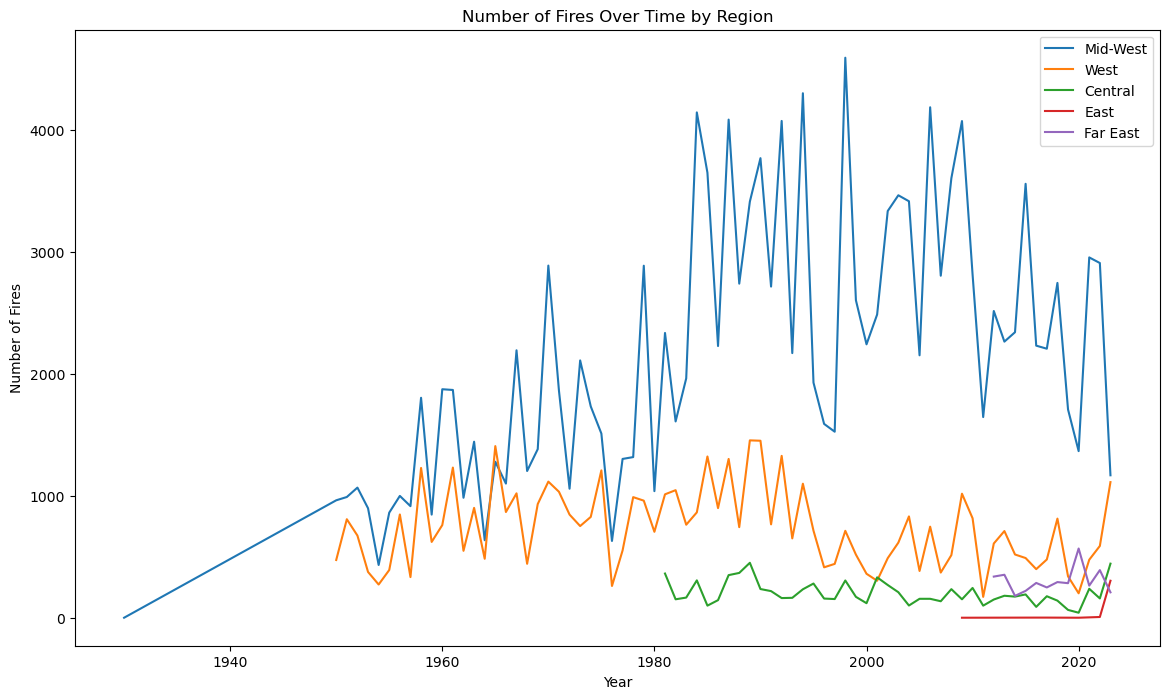

In [28]:
# Plotting the number of fires over time for each region
plt.figure(figsize=(14, 8))
for region in data_cleaned_filtered['Region'].unique():
    region_data = data_cleaned_filtered[data_cleaned_filtered['Region'] == region]
    region_data['YEAR'].value_counts().sort_index().plot(label=region)

plt.title('Number of Fires Over Time by Region')
plt.xlabel('Year')
plt.ylabel('Number of Fires')
plt.legend()
plt.show()


In [ ]:
#Causal Analysis

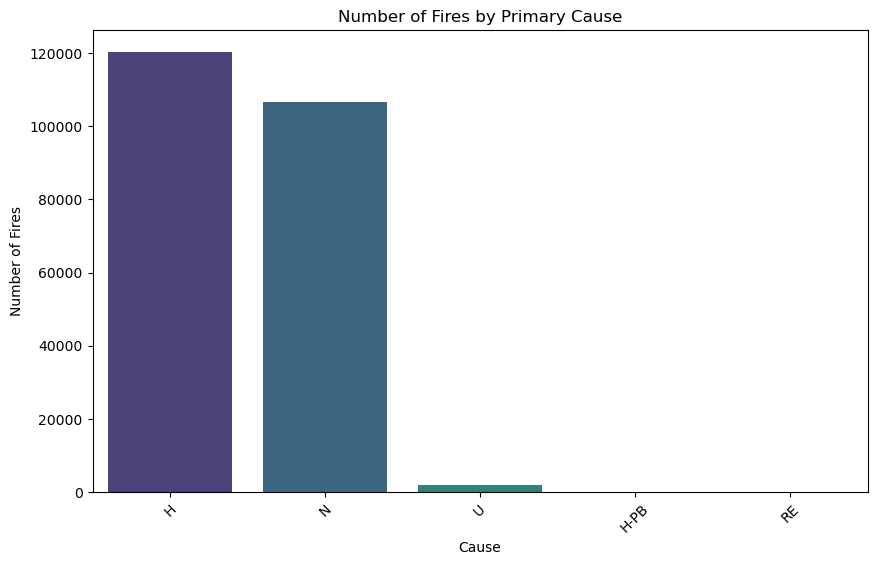

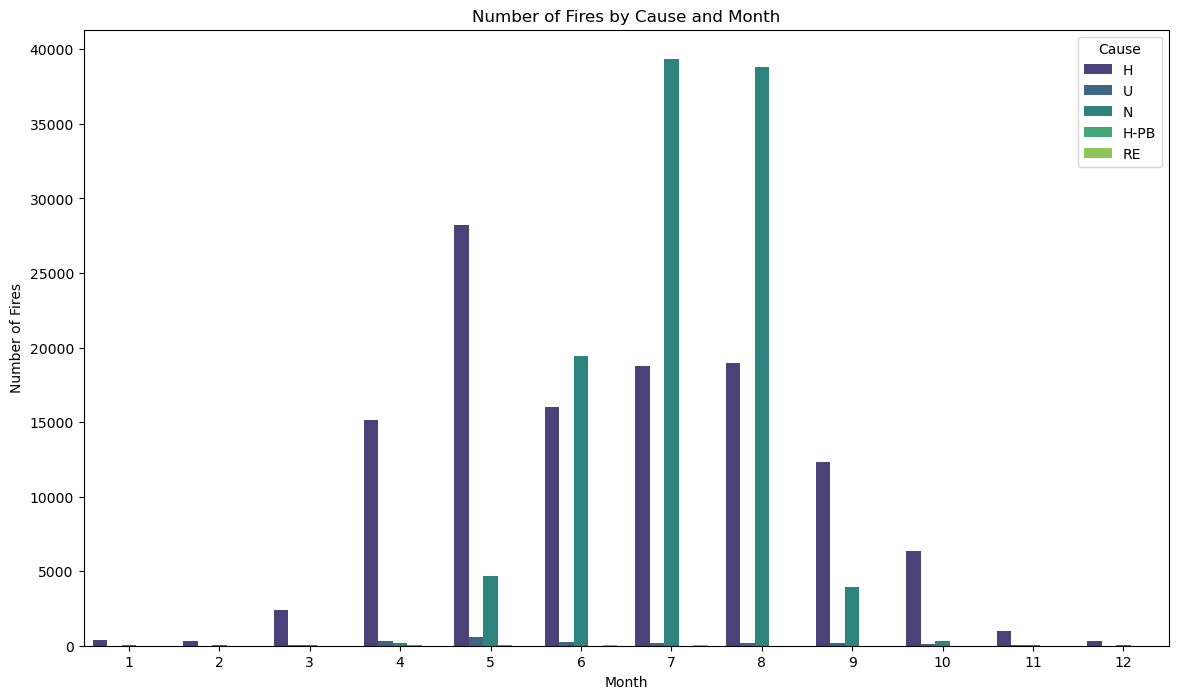

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# Number of fires by primary cause
plt.figure(figsize=(10, 6))
sns.countplot(data=data_cleaned_filtered, x='CAUSE', order=data['CAUSE'].value_counts().index, palette='viridis')
plt.title('Number of Fires by Primary Cause')
plt.xlabel('Cause')
plt.ylabel('Number of Fires')
plt.xticks(rotation=45)
plt.show()

# Number of fires by primary cause and month
plt.figure(figsize=(14, 8))
sns.countplot(data=data_cleaned_filtered, x='MONTH', hue='CAUSE', palette='viridis')
plt.title('Number of Fires by Cause and Month')
plt.xlabel('Month')
plt.ylabel('Number of Fires')
plt.legend(title='Cause')
plt.show()


In [ ]:
#Seasonal Analysis:

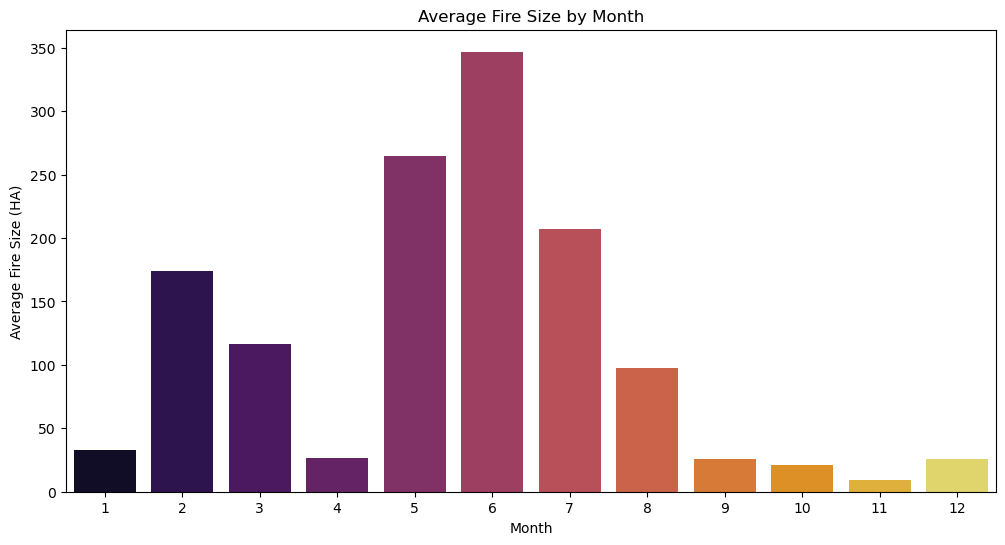

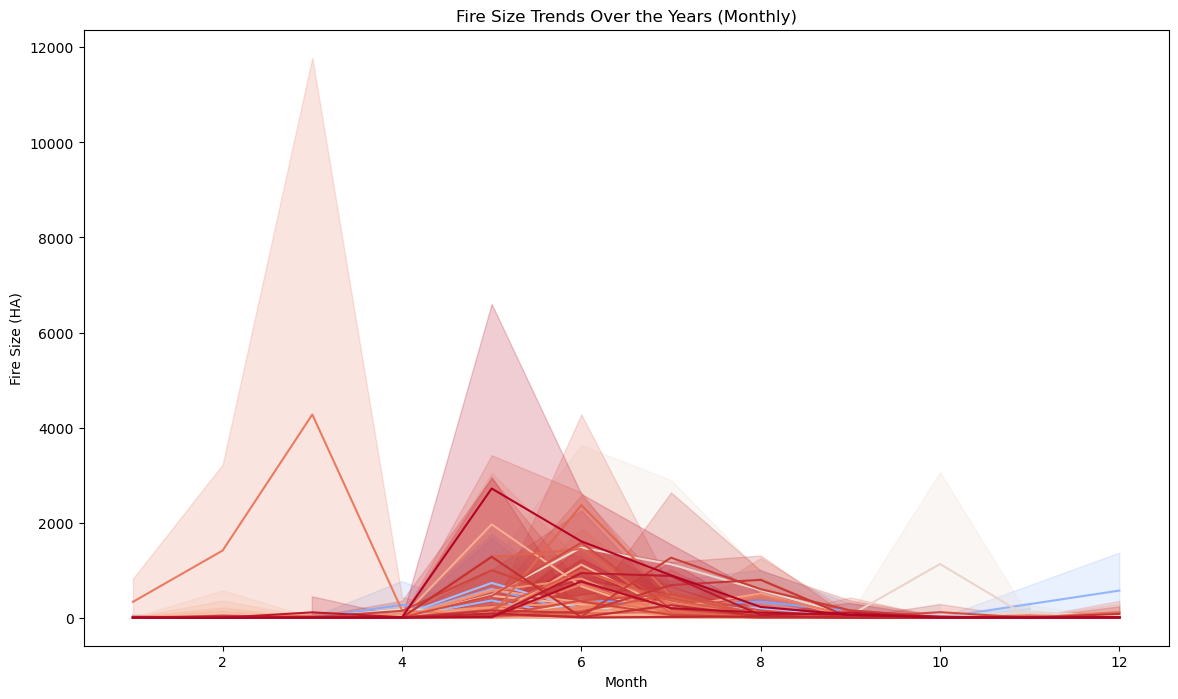

In [30]:
# Average fire size by month
monthly_avg_size = data_cleaned_filtered.groupby('MONTH')['SIZE_HA'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='MONTH', y='SIZE_HA', data=monthly_avg_size, palette='inferno')
plt.title('Average Fire Size by Month')
plt.xlabel('Month')
plt.ylabel('Average Fire Size (HA)')
plt.show()

# Fire incidents by month over the years
plt.figure(figsize=(14, 8))
sns.lineplot(data=data_cleaned_filtered, x='MONTH', y='SIZE_HA', hue='YEAR', palette='coolwarm', legend=None)
plt.title('Fire Size Trends Over the Years (Monthly)')
plt.xlabel('Month')
plt.ylabel('Fire Size (HA)')
plt.show()


In [ ]:
# Fire Duration Analysis:

/var/folders/n3/wq3qj7vn3c12xjhrsq0nrmcr0000gn/T/ipykernel_7869/3091383210.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned_filtered['REP_DATE'] = pd.to_datetime(data_cleaned_filtered['REP_DATE'], errors='coerce')
/var/folders/n3/wq3qj7vn3c12xjhrsq0nrmcr0000gn/T/ipykernel_7869/3091383210.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned_filtered['OUT_DATE'] = pd.to_datetime(data_cleaned_filtered['OUT_DATE'], errors='coerce')
/var/folders/n3/wq3qj7vn3c12xjhrsq0nrmcr0000gn/T/ipy

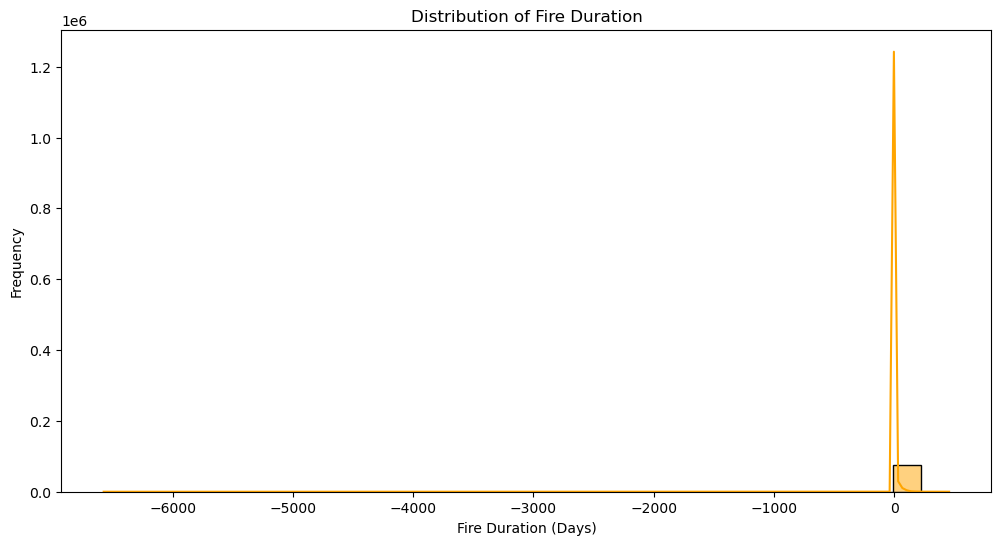

In [31]:
# Convert REP_DATE and OUT_DATE to datetime format if they aren't already
data_cleaned_filtered['REP_DATE'] = pd.to_datetime(data_cleaned_filtered['REP_DATE'], errors='coerce')
data_cleaned_filtered['OUT_DATE'] = pd.to_datetime(data_cleaned_filtered['OUT_DATE'], errors='coerce')

# Calculate fire duration in days
data_cleaned_filtered['FIRE_DURATION'] = (data_cleaned_filtered['OUT_DATE'] - data_cleaned_filtered['REP_DATE']).dt.days

# Plot distribution of fire duration
plt.figure(figsize=(12, 6))
sns.histplot(data_cleaned_filtered['FIRE_DURATION'].dropna(), kde=True, bins=30, color='orange')
plt.title('Distribution of Fire Duration')
plt.xlabel('Fire Duration (Days)')
plt.ylabel('Frequency')
plt.show()


In [ ]:
#Size Classification Analysis:

/var/folders/n3/wq3qj7vn3c12xjhrsq0nrmcr0000gn/T/ipykernel_7869/1806110628.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned_filtered['SIZE_CATEGORY'] = pd.cut(data_cleaned_filtered['SIZE_HA'], bins=bins, labels=labels)


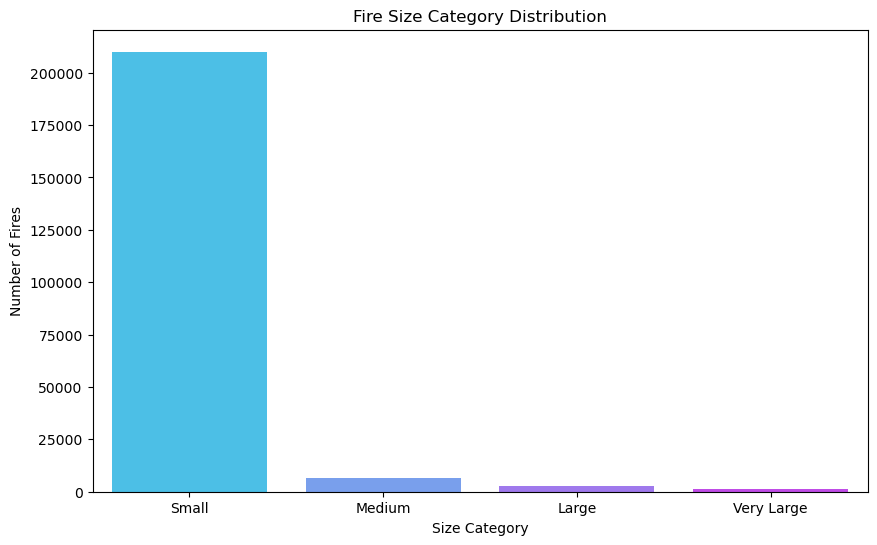

In [32]:
# Categorize fire sizes
bins = [0, 50, 500, 5000, data['SIZE_HA'].max()]
labels = ['Small', 'Medium', 'Large', 'Very Large']
data_cleaned_filtered['SIZE_CATEGORY'] = pd.cut(data_cleaned_filtered['SIZE_HA'], bins=bins, labels=labels)

# Plot the count of each size category
plt.figure(figsize=(10, 6))
sns.countplot(data=data_cleaned_filtered, x='SIZE_CATEGORY', palette='cool')
plt.title('Fire Size Category Distribution')
plt.xlabel('Size Category')
plt.ylabel('Number of Fires')
plt.show()


In [ ]:
data_cleaned_filtered.columns

In [33]:
data_cleaned['Fire_Occurrence'] = np.where(data_cleaned['SIZE_HA'] > 0, 1, 0)

features = ['LATITUDE', 'LONGITUDE', 'MONTH', 'DAY', 'YEAR', 'CAUSE']  
X = data_cleaned[features]
X = pd.get_dummies(X, columns=['CAUSE'], drop_first=True)
y = data_cleaned['Fire_Occurrence']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Handling Imbalanced Data - Using SMOTE for Oversampling
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Random Forest Model with Hyperparameter Tuning
# Define the hyperparameter grid for RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced', 'balanced_subsample']
}

# Initialize the Random Forest Classifier
rf_clf = RandomForestClassifier(random_state=42)

# RandomizedSearchCV for hyperparameter tuning
random_search = RandomizedSearchCV(
    rf_clf, 
    param_distributions=param_dist, 
    n_iter=20, 
    cv=3, 
    random_state=42, 
    n_jobs=-1,
    verbose=2
)

# Fit the model on the resampled training data
random_search.fit(X_train_resampled, y_train_resampled)

# Get the best model from RandomizedSearchCV
best_rf_clf = random_search.best_estimator_

# Model Evaluation
# Make predictions on the test set
y_pred = best_rf_clf.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Best Parameters: {random_search.best_params_}")
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 30, 'class_weight': 'balanced_subsample'}
Accuracy: 0.945995896212
Classification Report:
              precision    recall  f1-score   support

           0       0.39      0.77      0.52      2586
           1       0.99      0.95      0.97     66131

    accuracy                           0.95     68717
   macro avg       0.69      0.86      0.74     68717
weighted avg       0.97      0.95      0.95     68717

[CV] END class_weight=balanced_subsample, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  23.7s
[CV] END class_weight=balanced_subsample, max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=  30.7s
[CV] END class_weight=balanced_subsample, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  34.0s
[CV] END class_wei

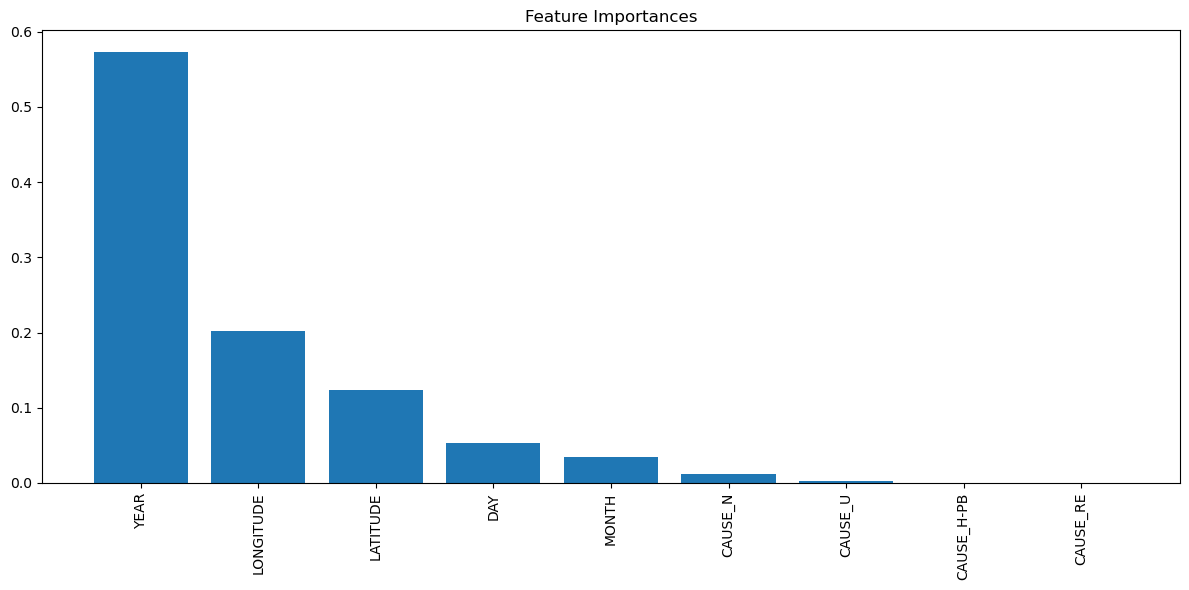

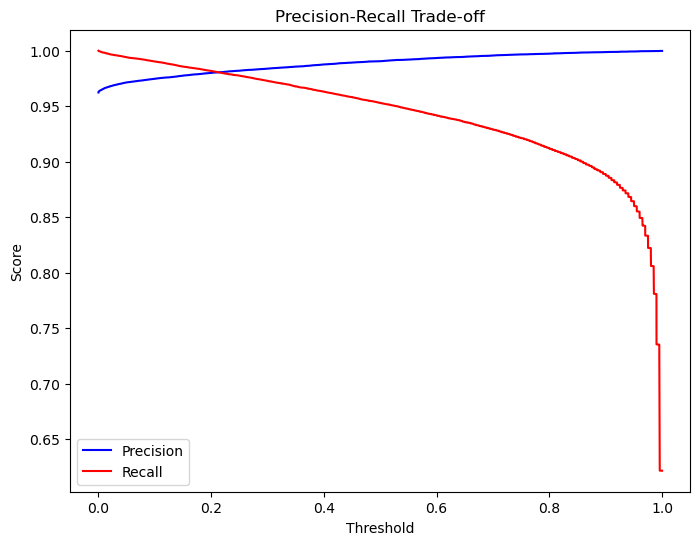

In [34]:
# Feature Importance
# Plot feature importance
feature_importances = best_rf_clf.feature_importances_
feature_names = X.columns
sorted_indices = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(12, 6))
plt.title('Feature Importances')
plt.bar(range(len(feature_importances)), feature_importances[sorted_indices], align='center')
plt.xticks(range(len(feature_importances)), feature_names[sorted_indices], rotation=90)
plt.tight_layout()
plt.show()

y_pred_proba = best_rf_clf.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision[:-1], label='Precision', color='b')
plt.plot(thresholds, recall[:-1], label='Recall', color='r')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall Trade-off')
plt.legend()
plt.show()

In [35]:
# Get the predicted probabilities
y_pred_proba = best_rf_clf.predict_proba(X_test)[:, 1]

# Adjust the decision threshold
threshold = 0.4  # Example threshold, adjust this based on the precision-recall trade-off
y_pred_adjusted = np.where(y_pred_proba >= threshold, 1, 0)

# Evaluate the model with the adjusted threshold
accuracy = accuracy_score(y_test, y_pred_adjusted)
report = classification_report(y_test, y_pred_adjusted)

print(f"Adjusted Threshold: {threshold}")
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

Adjusted Threshold: 0.4
Accuracy: 0.9529228575170627
Classification Report:
              precision    recall  f1-score   support

           0       0.42      0.69      0.52      2586
           1       0.99      0.96      0.98     66131

    accuracy                           0.95     68717
   macro avg       0.71      0.83      0.75     68717
weighted avg       0.97      0.95      0.96     68717

